In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import PolynomialFeatures



### 2 big problems in the dataset: 
-  unbalanced classes
-  too many features


### (trying to use Pipeline)

In [2]:
dataset_full = pd.read_csv("final_dataset_1.csv")

In [3]:
dataset_full.shape

(57143, 22)

In [4]:
dataset_full.readmitted.value_counts()

readmitted
NO     33964
>30    18114
<30     5065
Name: count, dtype: int64

In [5]:
dataset_full

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,number_emergency,number_inpatient,diag_1,number_diagnoses,A1Cresult,insulin,readmitted,n_treatments,rate_down_treatments,rate_up_treatments
0,Caucasian,Female,[80-90),urgent,to_home,another_medical_facility/other,13,missing,68,2,...,0,0,circulatory,8,missing,Steady,NO,2,0.0,0.0
1,Caucasian,Female,[90-100),elective,another_medical_facility,another_medical_facility/other,12,InternalMedicine,33,3,...,0,0,circulatory,8,missing,Steady,NO,2,0.0,0.0
2,Caucasian,Male,[40-50),emergency,to_home,emergency,1,missing,51,0,...,0,0,neoplasms,5,missing,Steady,NO,2,0.0,0.0
3,AfricanAmerican,Female,[40-50),emergency,to_home,emergency,9,missing,47,2,...,0,0,diabetes,9,missing,Steady,>30,1,0.0,0.0
4,Caucasian,Male,[50-60),urgent,to_home,referral,3,missing,31,6,...,0,0,circulatory,9,missing,Steady,>30,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57138,Caucasian,Female,[70-80),emergency,to_home,emergency,9,missing,50,2,...,0,0,digestive,9,>7,Steady,>30,2,0.0,0.5
57139,Other,Female,[40-50),emergency,to_home,emergency,14,missing,73,6,...,1,0,genitourinary,9,>8,Up,>30,2,0.0,0.5
57140,Other,Female,[60-70),emergency,to_home,emergency,2,missing,46,6,...,1,1,injury,9,missing,Steady,>30,1,0.0,0.0
57141,Caucasian,Female,[80-90),emergency,to_home,emergency,5,missing,76,1,...,1,0,other,9,missing,Up,NO,1,0.0,1.0


In [6]:
print(dataset_full.admission_type_id.value_counts())

admission_type_id
emergency    32730
elective     12615
urgent       11512
other          286
Name: count, dtype: int64


In [ ]:
#decided to keep them!
#dataset = dataset_full.drop(['num_lab_procedures','gender','Rate_up'],axis = 1)

In [7]:
dataset_full.shape

(57143, 22)

In [8]:
y = dataset_full['readmitted']

In [9]:
X = dataset_full.drop(columns = "readmitted", axis = 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15,stratify=y, random_state=42)

In [11]:
y_test.value_counts() # con stratified andiamo a tenere le stesse proporzioni tra le classi

readmitted
NO     5095
>30    2717
<30     760
Name: count, dtype: int64

In [12]:
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

In [13]:
smote_nc = SMOTENC(categorical_features=categoric_columns, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

#da usare solo sul training set o su tutto? solo sul training!
#why?To avoid data leakage:
#If you apply SMOTENC before splitting, the synthetic samples generated will leak information from the test set into training, inflating performance metrics unrealistically.

In [14]:
X_resampled.shape

(86607, 21)

In [15]:
y_resampled.value_counts()

readmitted
<30    28869
NO     28869
>30    28869
Name: count, dtype: int64

In [16]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numeric_columns),
                                  ('cat',OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)])

In [17]:
pipeline = Pipeline([('preproc',preprocessor),
                     ('classifier', LogisticRegression(max_iter = 1000))])

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [19]:
y_pred = pipeline.predict(X_test)

In [20]:
cm = confusion_matrix(y_test, y_pred)

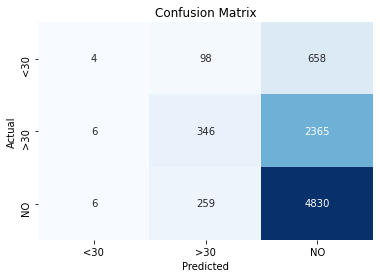

In [21]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracy_score(y_test, y_pred)

0.6042930471301913

### Trying to use a Logistic Regression on the augmented dataset (using SMOTENC)

In [30]:
#scores_with_SMOTENC = cross_val_score(pipeline, X_resampled, y_resampled, cv=5)
#scores_with_SMOTENC

#perchè CV qui? per valutare la performance devo usare il test set! o sbaglio

In [23]:
pipeline.fit(X_resampled,y_resampled)

KeyboardInterrupt: 

In [ ]:
y_pred_SMOTENC = pipeline.predict(X_test)

In [33]:
cm_SMOTENC = confusion_matrix(y_test, y_pred_SMOTENC)

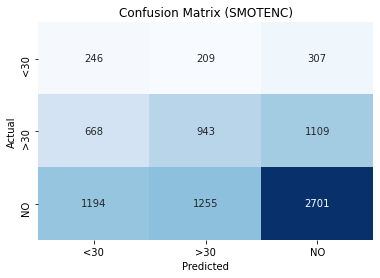

In [34]:
sns.heatmap(cm_SMOTENC, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SMOTENC)')
plt.show()

In [35]:
accuracy_score(y_test, y_pred_SMOTENC)

#com'è possibile che l'accuracy rimane uguale?

0.45064874884151995

Are there problems related to bias or variance in the model?

In [36]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='accuracy'
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("Accuracy")
plt.legend(); plt.grid()
plt.show()


KeyboardInterrupt: 

Come interpretare?

Se la curva di training è molto alta (vicina a 1) e la validation bassa, hai overfitting → serve regolarizzazione o modello più semplice.
Se entrambe sono basse → modello troppo semplice, serve più complessità o più dati.
Se curve convergono e alte → modello ok.

increasing the training size, the model is learning. However, with the maximum training size, we have an accuracy on the training set which is slightly higher than the one on the validation set. 
This probably means that our model suffer of quite high bias. -> INCREASE COMPLEXITY OF THE MODEL

At this point, trying regularization techniques on the model looks useless, but let's see what happens...

Let's try to tune the Logistic regression model changing the regularization penalty

In [ ]:
from sklearn.model_selection import validation_curve
C_range = [10**exp for exp in [-5,-4,-3,-2,-1,0,1,2,3]]
train_scores, val_scores = validation_curve(
    pipeline, X_resampled, y_resampled,
    param_name="classifier__C", param_range=C_range,
    cv=5, scoring="accuracy"
)


KeyboardInterrupt: 

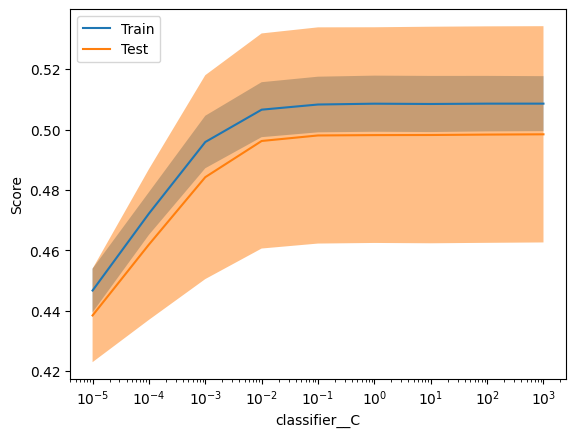

In [ ]:
from sklearn.model_selection import ValidationCurveDisplay
#ValidationCurveDisplay(pipeline, param_name, param_range, train_scores, val_scores, score_name=None)
display = ValidationCurveDisplay(
    param_name="classifier__C", param_range=np.array(C_range),
    train_scores=train_scores, test_scores=val_scores, score_name="Score"
)
display.plot()
plt.show()

let's try to add polynomial features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

preprocessor2 = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)
])

pipeline2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [ ]:
train_sizes2, train_scores2, val_scores2 = learning_curve(
    estimator=pipeline2,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='accuracy'
)



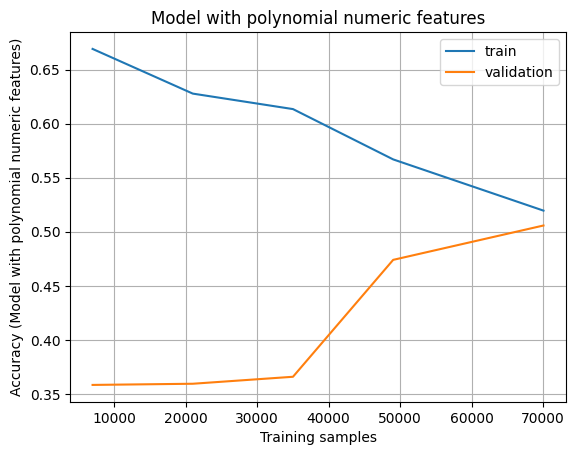

In [ ]:
plt.plot(train_sizes2, train_scores2.mean(axis=1), label='train')
plt.plot(train_sizes2, val_scores2.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("Accuracy (Model with polynomial numeric features)")
plt.title("Model with polynomial numeric features")
plt.legend(); plt.grid()
plt.show()

In [ ]:
#C = [10**exp for exp in [-3,-2,-1,0,1,2,3]]

In [ ]:
#param_grid = {'classifier__C': C}

In [ ]:
#grid_search_LogReg = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), verbose=3)

In [55]:
#grid_search_LogReg.fit(X_resampled, y_resampled)
#changing C doesn't change anything

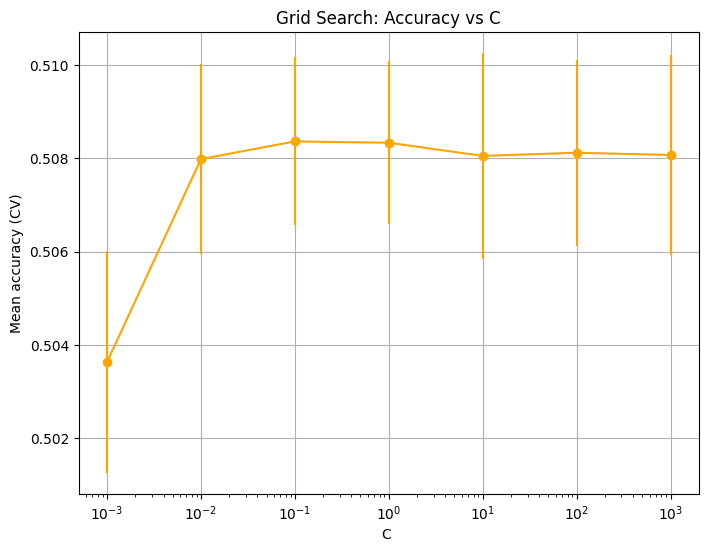

In [ ]:
C_values = grid_search_LogReg.param_grid['classifier__C']  
mean_scores = grid_search_LogReg.cv_results_['mean_test_score']
std_scores = grid_search_LogReg.cv_results_['std_test_score']

plt.figure(figsize=(8, 6))
plt.errorbar(C_values, mean_scores, yerr=std_scores, fmt='-o', color = 'orange')
plt.xscale('log')
plt.xlabel('C ')
plt.ylabel('Mean accuracy (CV)')
plt.title('Grid Search: Accuracy vs C')
plt.grid(True)
plt.show()

## From Decision Trees to Random Forest

We now move on implementing a **Decision Tree** model, which in theory allows for much greater complexity and non-linear decision boundaries compared to Logistic Regression. However, this added flexibility comes at the cost of a higher risk of overfitting and increased variance.

Let's start by implementing an extremely simple decision tree, with maximum depth 1, which means 1 split on a single optimal feature

In [ ]:
# define the pipeline
pipeline_tree = Pipeline([('preproc', preprocessor),
                          ('classifier', DecisionTreeClassifier(max_depth=1, random_state=42))])
# fit the model
pipeline_tree.fit(X_resampled,y_resampled)

# make predictions on the training and test set
y_pred_training=pipeline_tree.predict(X_resampled)
y_pred=pipeline_tree.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_training, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))


On training set:
Accuracy : 0.4114678952047756
F1 (weighted): 0.3286795182644264
On test set:
Accuracy : 0.3616425571628558
F1 (weighted): 0.3517951012787853


The performance on the test set is just above the trivial guess of 0.33.  

In [79]:
# cross-validation accuracy scores
scores_tree = cross_val_score(pipeline_tree, X_resampled, y_resampled, cv=5)
scores_tree

array([0.35757996, 0.42206443, 0.42543733, 0.41579585, 0.42601466])

Let's now go on exploring how our Decision Tree baseline model learns as more data are fed in...

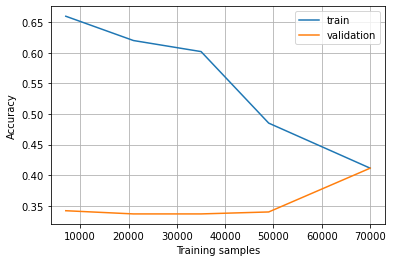

In [25]:
train_sizes_stump, train_scores_stump, val_scores_stump = learning_curve(
    estimator=pipeline_tree,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='accuracy'
)

plt.plot(train_sizes_stump, train_scores_stump.mean(axis=1), label='train')
plt.plot(train_sizes_stump, val_scores_stump.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("Accuracy")
plt.legend(); plt.grid()
plt.show()

We see that a single Decision Tree, with depth 1, is a biased model, being extremely simple.

Here below, we proceed analysing how the **maximum tree depth** impacts on Variance-Bias tradeoff:

In [26]:
max_depth_range = range(1,30)
train_scores_trees, val_scores_trees = validation_curve(
    pipeline_tree, X_resampled, y_resampled,
    param_name="classifier__max_depth", param_range=max_depth_range,
    cv=5, scoring="f1_macro"
)

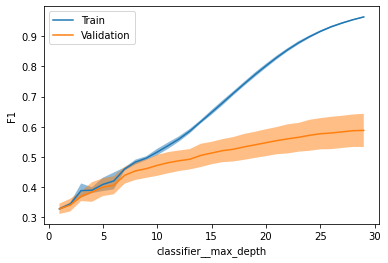

In [28]:
display_trees = ValidationCurveDisplay(
    param_name="classifier__max_depth", param_range=max_depth_range,
    train_scores=train_scores_trees, test_scores=val_scores_trees, score_name="F1"
)
display_trees.plot()
plt.legend(['Train', 'Validation'])
plt.show()

We now perform a **GridSearch** to be more accurate at choosing the most appropriate max_depth, being aware of the fact that the tuned model will be prone to overfitting, as shown by the plot above.


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# pipeline
pipeline_tree = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# grid of hyperparameter to search
param_grid = {
    'classifier__max_depth': range(15, 30)
}

# grid search
grid = GridSearchCV(pipeline_tree, param_grid, cv=5, n_jobs=-1)

# tune hyperpar
grid.fit(X_resampled, y_resampled)
print(grid.best_params_)

{'classifier__max_depth': 29}


Now, let's fit the model and perform a final evaluation

In [61]:
# fit model
final_model=grid.best_estimator_
final_model.fit(X_resampled, y_resampled)

#final evaluation
# make predictions on the training and test set
y_pred_tree_training=final_model.predict(X_resampled)
y_pred_tree=final_model.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_tree_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_tree_training, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_tree))
print("F1 (weighted):", f1_score(y_test, y_pred_tree, average='weighted'))

On training set:
Accuracy : 0.9739051115960604
F1 (weighted): 0.9739051675843498
On test set:
Accuracy : 0.437120858609426
F1 (weighted): 0.4552982983903508


## Random Forest

To improve upon a single decision tree, which often suffers from high variance, we implement a **Random Forest** model. Random Forest reduces variance by averaging the predictions of many decision trees trained on different subsets of the data and features.

Let's run a 'baseline' Random Forest:

In [24]:
pipeline_rf = Pipeline([('preproc', preprocessor),
                          ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

Let's start by visualizing whether the model learns as data are fed in, by looking at the F1 score on the training and validation sets 

In [ ]:
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    estimator=pipeline_rf,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='f1_macro'
)

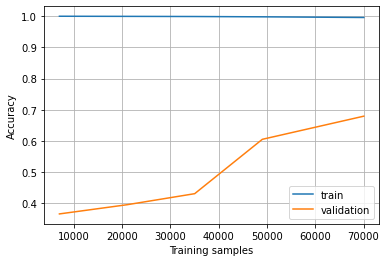

In [ ]:
plt.plot(train_sizes_rf, train_scores_rf.mean(axis=1), label='train')
plt.plot(train_sizes_rf, val_scores_rf.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("F1")
plt.legend(); plt.grid()
plt.show()


Notice that the blue 'train' line remains at 1.0 across all configurations.
This is because Random Forest, with 100 trees, that can be as deep as possible by default, is complex enough to perfectly fit the resampled training data, achieving a maximum F1 score of 1.

Here below with the function 'validation_curve' of sklearn we see how the number of trees, which is represented by n_estimator, affects the performance of the model.

In [ ]:
n_estimators_range = [10,100,1000]
train_scores_rf, val_scores_rf = validation_curve(
    pipeline_rf, X_resampled, y_resampled,
    param_name="classifier__n_estimators", param_range=n_estimators_range,
    cv=5, scoring="f1_macro"
)

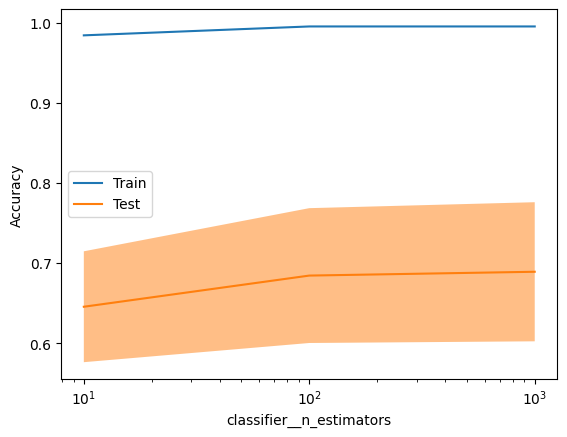

In [ ]:
display_rf = ValidationCurveDisplay(
    param_name="classifier__n_estimators", param_range=np.array(n_estimators_range),
    train_scores=train_scores_rf, test_scores=val_scores_rf, score_name="F1"
)
display_rf.plot()
plt.legend(["Train", "Validation"])
plt.show()

 Let's see how the Random Forest baseline performs.

In [ ]:
#Keywords: SMOTENC, no hyperpar-tuning

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # applies transformations to both numerical and categorical variables
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train pipeline on resampled data
pipeline_rf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_rf_training=pipeline_rf.predict(X_resampled)
y_pred_rf = pipeline_rf.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("F1 (weighted):", f1_score(y_test, y_pred_rf, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729914808822
On test set:
Accuracy : 0.5307979468035464
F1 (weighted): 0.5227970225962216


### Cross-Validation of Random Forest

Let's now finetune the hyperparameters of the Random Forest model to improve its generalization performance.

In [65]:
param_grid = {
    'classifier__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'classifier__n_estimators': [10, 100, 500]
}

grid_search = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid,         
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

grid_search.fit(X_resampled, y_resampled)

print("Best parameters :", grid_search.best_params_)
print("Best CV F1 Macro:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters : {'classifier__max_features': 0.5, 'classifier__n_estimators': 500}
Best CV F1 Macro: 0.64427005866446


Rerunning the model setting the optimal parameters...

In [ ]:
#keywords:SMOTENC, hyperpar-tuned

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # applies transformations to both numerical and categorical variables
    ('classifier', RandomForestClassifier(n_estimators=500, max_features=0.5, random_state=42))
])

# Train pipeline on resampled data
pipeline_rf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_rf_training = pipeline_rf.predict(X_resampled)
y_pred_rf = pipeline_rf.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("F1 (weighted):", f1_score(y_test, y_pred_rf, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729918801621
On test set:
Accuracy : 0.5348810079328045
F1 (weighted): 0.5257403639959874


This model improves F1 performances(we will see that this model in terms of performances is actually among the best ones!)

### Two Roads in Feature Engineering: Adding New Features vs. Selecting the Best

As with Logistic Regression, we follow a two-fold approach: on one hand, we assess whether adding polynomial terms leads to a significant improvement in model performance; on the other hand, we conduct a feature importance analysis and use it to guide feature selection, with the goal of enhancing model explainability.

 We enrich the feature space with interaction terms to capture higher-order dependencies potentially missed by Random Forest.
 We now define a new preprocessor including interaction terms up to degree 2 to enrich the feature space.

In [28]:
preprocessor3 = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('scaler', StandardScaler())
    ]), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)
])

In [82]:
#Keywords: SMOTENC, no hyperpar-tuning, preprocessor3

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf3 = Pipeline([
    ('preprocessor', preprocessor3),  
    ('classifier', RandomForestClassifier(n_estimators=100,  random_state=42))
])

# Train pipeline on resampled data
pipeline_rf3.fit(X_resampled, y_resampled)

# Make predictions on the training and test set
y_pred_rf3_training= pipeline_rf3.predict(X_resampled)
y_pred_rf3 = pipeline_rf3.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf3_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf3_training, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf3))
print("F1 (weighted):", f1_score(y_test, y_pred_rf3, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729916806537
On test set:
Accuracy : 0.5461969202053196
F1 (weighted): 0.5315237581251913


The performance of the model above — a Random Forest trained on an extended feature space — slightly improves upon that of the model trained on the original feature set. 

Once again, we see how the number of trees which is represented by n_estimator affects the performance of the model.

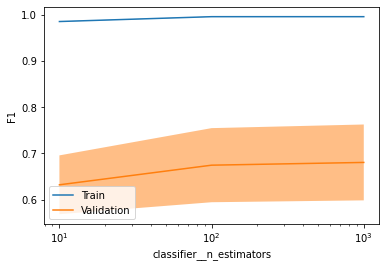

In [56]:
n_estimators_range = [10,100,1000]
train_scores_rf, val_scores_rf = validation_curve(
    pipeline_rf3, X_resampled, y_resampled,
    param_name="classifier__n_estimators", param_range=n_estimators_range,
    cv=5, scoring="f1_macro"
)
display_rf = ValidationCurveDisplay(
    param_name="classifier__n_estimators", param_range=np.array(n_estimators_range),
    train_scores=train_scores_rf, test_scores=val_scores_rf, score_name="F1"
)
display_rf.plot()
plt.legend(["Train", "Validation"])
plt.show()

Cross-Validation again on extended feature space:

In [ ]:
# define parameter grid
param_grid = {
    'classifier__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'classifier__n_estimators': [10, 100, 500]
}

# perform GridSearch on optimal parameters
grid_search = GridSearchCV(
    pipeline_rf3,
    param_grid=param_grid,         
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

print("Best parameters :", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters : {'classifier__max_features': 0.5, 'classifier__n_estimators': 500}


Rerunning the model with the optimal hyperparameters:

In [ ]:
#Keywords: SMOTENC, hyperpar-tuned

# Define a pipeline that first performs preprocessing and then fits a RandomForestClassifier
pipeline_rf4 = Pipeline([
    ('preprocessor', preprocessor),  # applies transformations to both numerical and categorical variables
    ('classifier', RandomForestClassifier(n_estimators=500, max_features=0.5 , random_state=42))
])

# Train pipeline on resampled data
pipeline_rf4.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_rf4_training = pipeline_rf4.predict(X_resampled)
y_pred_rf4 = pipeline_rf4.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_rf4_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_rf4_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf4))
print("F1 (weighted):", f1_score(y_test, y_pred_rf4, average='weighted'))

On training set:
Accuracy : 0.9998729894812197
F1 (weighted): 0.9998729918801621
On test set:
Accuracy : 0.5348810079328045
F1 (weighted): 0.5257403639959874


Notice that F1 performance on the test set does not increase after hyperparameter tuning. This may be related to the fact that this model with this data has reached a 'plateau'.

Given the marginal gain and the trade-off in interpretability, we favor the original feature space. We now proceed with feature importance analysis and selection based on this more interpretable setup.

## Feature Importance and Selection for Random Forest

We compute feature significance using two approaches. We start with **feature_importances_**, based on Gini scores, then we go on computing **permutation_importance**, as explained below.

What is feature importance for feature j? 

$$\text{Feature Importance}_j = \frac{1}{T} \sum_{t=1}^{T} \sum_{\text{nodes m with split on j}} \frac{N_{t,m}}{N} \Delta I_{t,m}$$
where:
- $T$ is the number of trees in the forest
- $N_t,m$ is the number of samples in node m of tree $t$
- $N$ is the total number of samples in the training size
- $\Delta I_{t,m}$ is the Gini index for the split on node $m$ on tree $t$

In [31]:
# Estract the model from the pipeline
rnd_clf=pipeline_rf.named_steps['classifier']

# feature importance
rnd_clf.feature_importances_

array([0.08552347, 0.16182645, 0.05264537, 0.13050189, 0.01881137,
       0.01110071, 0.0191085 , 0.05887502, 0.04318221, 0.03078819,
       0.02693247, 0.00069075, 0.01722843, 0.00146868, 0.00137721,
       0.02553525, 0.00089962, 0.00201538, 0.00442967, 0.00869901,
       0.01157699, 0.01544194, 0.01620721, 0.01414723, 0.00419041,
       0.01036637, 0.00046841, 0.01038416, 0.00079723, 0.01522167,
       0.01137788, 0.00705819, 0.00403089, 0.00474655, 0.00631102,
       0.00337711, 0.01739139, 0.00572844, 0.00918801, 0.0112486 ,
       0.00813739, 0.0093152 , 0.00586853, 0.00494449, 0.01689574,
       0.01311583, 0.00231581, 0.00227045, 0.01548458, 0.0165837 ,
       0.01617134, 0.00799754])

In [32]:
# get the transformer OneHotEncoder from the pipeline
ohe = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']

# Get the names of the numeric features 
num_feats = numeric_columns

# Get the names of the categorical features 
cat_feats = ohe.get_feature_names_out(categoric_columns)

# Combine the names of the features
feature_names = np.concatenate([num_feats, cat_feats])

<AxesSubplot:>

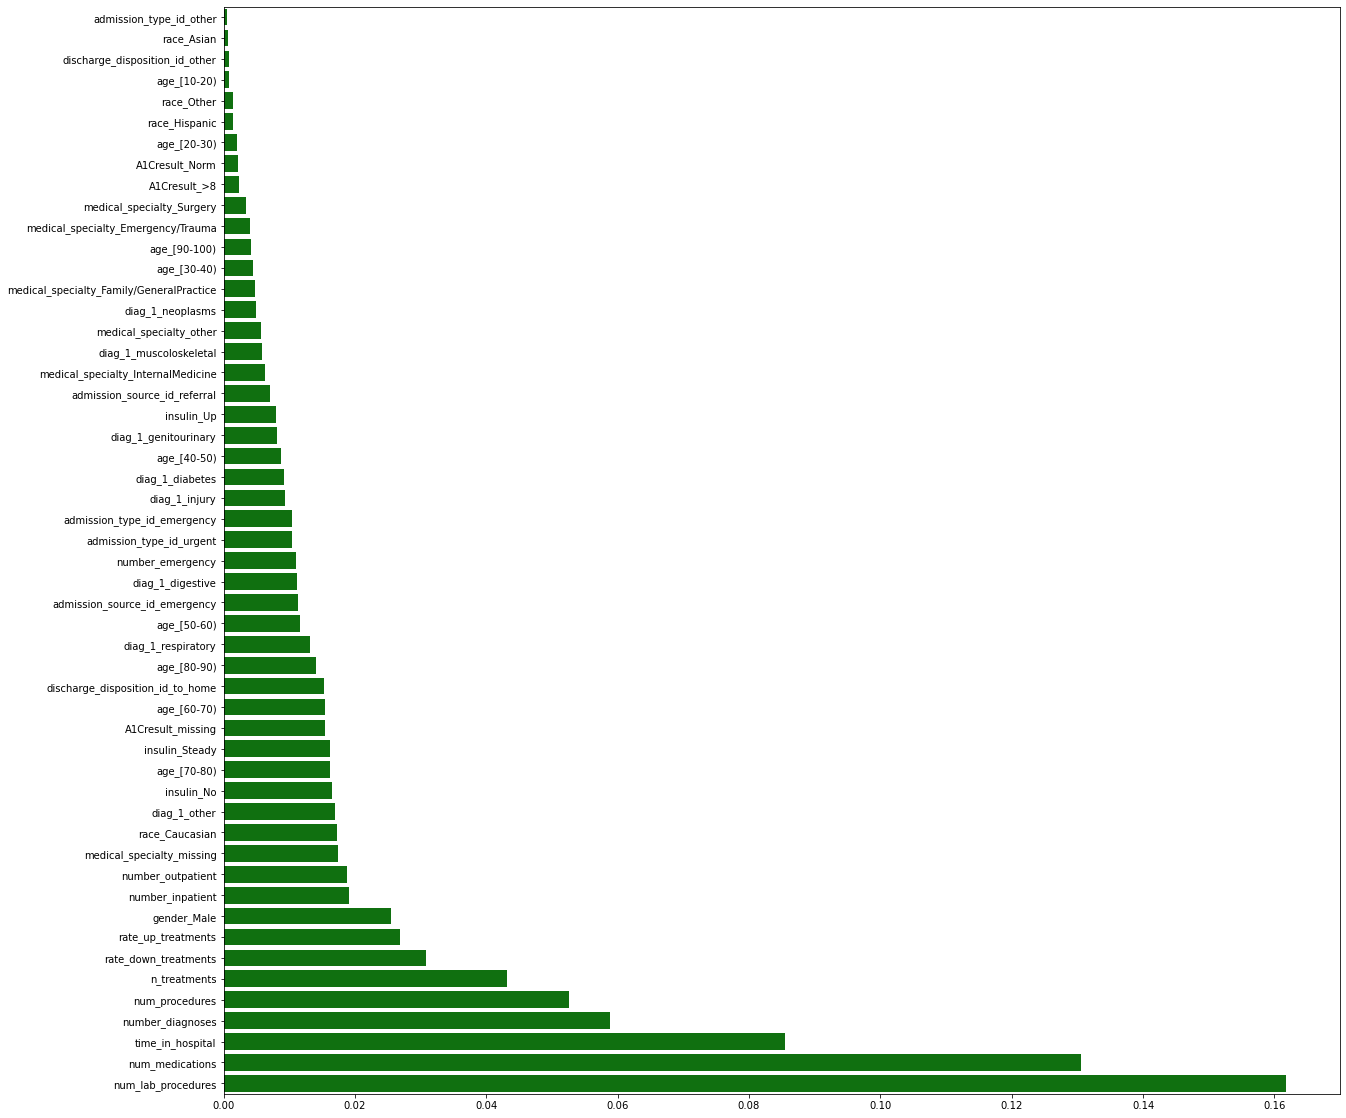

In [33]:
GiniScore,j=np.sort(rnd_clf.feature_importances_),np.argsort(rnd_clf.feature_importances_)
plt.figure(figsize=(20, 20)) 
sns.barplot(y=feature_names[j], x=GiniScore, color='g', )

Notice that impurity based feature importance, computed as above, may be biased towards numerical features, since they allow many more splits than categorical ones with few categories. Hence, it improves almost randomly the model performance. This appears to be true in our case.

Let's now compute the **permutation importance**.

This method is known to overcome the bias of impurity-based feature importance, especially when dealing with numerical features or categorical ones with many levels.
The idea is simple: we measure how the model's performance metric (e.g. accuracy, F1) drops when a single feature's values are randomly shuffled.
The larger the drop, the more important the feature is. To make the estimate more stable, the process is repeated several times and averaged.

Let's compute it below.

In [47]:
def f1_weighted_score(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y, y_pred, average='weighted')

# Compute importances
result = permutation_importance(pipeline_rf, X_test, y_test, n_repeats=5, random_state=42, scoring=f1_weighted_score)

# Create Series and sort
f_importances = pd.Series(result.importances_mean, index=X_test.columns)
f_importances_sorted = f_importances.sort_values()  



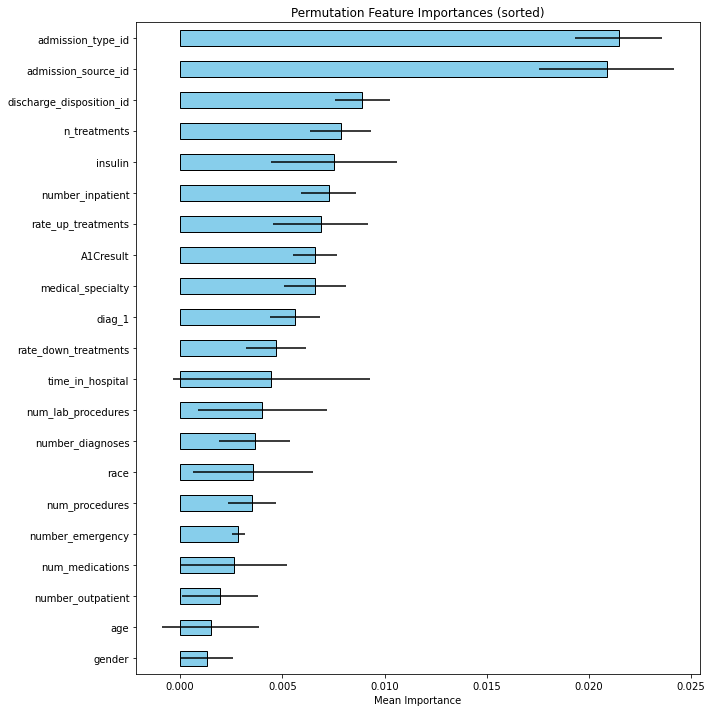

In [49]:
# Plot
plt.figure(figsize=(10, 10))
f_importances_sorted.plot.barh(
    xerr=result.importances_std[[X_test.columns.get_loc(col) for col in f_importances_sorted.index]],  
    color="skyblue",
    edgecolor="black"
)
plt.title("Permutation Feature Importances (sorted)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

Here above, we see that as a matter of fact the most relevant features are categorical. Random Forest tend to detect the importance of **admission_type_id** and **admission_source_id**. 

As for 'admission_type_id', this is reasonable, as 'emergence' or 'urgent' admissions often indicate more severe conditions, increasing readmission risk, while 'elective' refer to not so life-death procedures. Talking about 'admission_source_id', once again the reasoning is similar: 'emergency' refers to much urgent patients than 'referral'.
These features act as proxies for clinical urgency and patient fragility at entry. 
Notice that 'admission_source_id' is also very significant in the logistic regression.

 ### Feature Selection for Random Forest

While we have already identified two features as particularly significant, removing all others would be too drastic. Therefore, we set a feature importance **threshold of 0.005**, which retains approximately 2/3 of the variables and ensures a balance between simplification and preserving predictive power.

In [ ]:
threshold = 0.005
low_importance = f_importances_sorted[f_importances_sorted < threshold]
selected_features=[]
for feature, importance in low_importance.items():
    selected_features.append(feature)

print(selected_features)


['gender', 'age', 'number_outpatient', 'num_medications', 'number_emergency', 'num_procedures', 'race', 'number_diagnoses', 'num_lab_procedures', 'time_in_hospital', 'rate_down_treatments']


pandas.core.series.Series

In [ ]:
X_resampled_FeatureSel_rf=X_resampled.drop(selected_features, axis=1, inplace=False)
X_test_FeatureSel_rf=X_test.drop(selected_features, axis=1, inplace=False)

# numeric and categorical features
numeric_columns_FeatureSel = X_resampled_FeatureSel_rf.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns_FeatureSel = X_resampled_FeatureSel_rf.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

#define preprocessor
preprocessor_FeatureSel = ColumnTransformer([('num', StandardScaler(), numeric_columns_FeatureSel),
                                  ('cat',OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns_FeatureSel )])

# Define a pipeline 
pipeline_rf_FeatureSel = Pipeline([
    ('preprocessor', preprocessor_FeatureSel), 
    ('classifier', RandomForestClassifier(n_estimators=500, max_features=0.5 , random_state=42))
])

# Train pipeline on resampled data
pipeline_rf_FeatureSel.fit(X_resampled_FeatureSel_rf, y_resampled)

# Make predictions on the test set
y_pred_FeatureSel_rf_training = pipeline_rf_FeatureSel.predict(X_resampled_FeatureSel_rf)
y_pred_FeatureSel_rf = pipeline_rf_FeatureSel.predict(X_test_FeatureSel_rf)


# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_FeatureSel_rf_training))
print("F1 (weighted):", f1_score(y_resampled, y_pred_FeatureSel_rf_training, average='weighted'))


# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_FeatureSel_rf))
print("F1 (weighted):", f1_score(y_test, y_pred_FeatureSel_rf, average='weighted'))


On training set:
Accuracy : 0.6341866130913205
F1 (weighted): 0.6344117535117745
On test set:
Accuracy : 0.4437704153056463
F1 (weighted): 0.4648913816358524


After removing the unimportant features, we see that the performance of the model slightly decreases. However, this **loss is minimal** with respect to the number of features that have been excluded. Furthermore, it may positively contribute to model explainability. We investigate it below.

Now, let's see again how important are the remained features...

In [59]:
# Compute importances
result_FeatureSel = permutation_importance(pipeline_rf_FeatureSel, X_test_FeatureSel_rf, y_test, n_repeats=5, random_state=42, scoring=f1_weighted_score)

# Create Series and sort
f_importances_FeatureSel = pd.Series(result_FeatureSel.importances_mean, index=X_test_FeatureSel_rf.columns)
f_importances_sorted_FeatureSel = f_importances_FeatureSel.sort_values()  

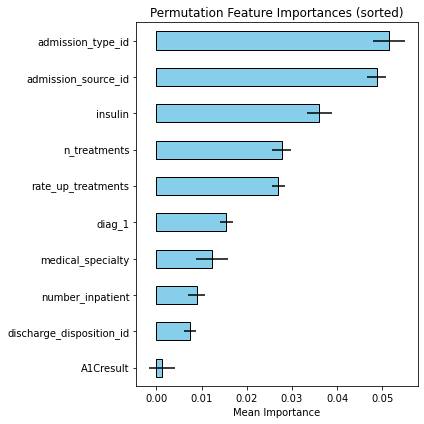

In [65]:
# Plot
plt.figure(figsize=(6, 6))
f_importances_sorted_FeatureSel.plot.barh(
    xerr=result_FeatureSel.importances_std[[X_test_FeatureSel_rf.columns.get_loc(col) for col in f_importances_sorted_FeatureSel.index]],  
    color="skyblue",
    edgecolor="black"
)
plt.title("Permutation Feature Importances (sorted)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

We see that the 2 most significant features remain such. Also the following 3 are important in the original model. On the other hand, 'discharge_disposition_id' drops a little. 

Let's now go on trying a different model...

## Boosting

In [72]:
# Encode class labels for training and test sets
le = LabelEncoder()
y_resampled_enc = le.fit_transform(y_resampled)   # Encoded target for balanced training set
y_test_enc = le.transform(y_test)                 # Encoded target for original test set

# Define pipeline: preprocessing + XGBoost classifier
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        verbosity=0
    ))
])

# Hyperparameter grid 
param_grid = {
    'classifier__n_estimators': [100, 300, 500, 700],
    'classifier__max_depth': [3, 5, 7]
}

# Perform Grid Search 
grid_search = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,
    verbose=3,
    n_jobs=-1,
    error_score='raise'
)

# Fit on resampled (balanced) training data
grid_search.fit(X_resampled, y_resampled_enc)

# Extract best model from the grid search
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the train and test set
y_pred_xgb_train = best_model.predict(X_resampled)
y_pred_xgb = best_model.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled_enc, y_pred_xgb_train))
print("F1 (weighted):", f1_score(y_resampled_enc, y_pred_xgb_train, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test_enc, y_pred_xgb))
print("F1 (weighted):", f1_score(y_test_enc, y_pred_xgb, average='weighted'))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'classifier__max_depth': 7, 'classifier__n_estimators': 700}
On training set:
Accuracy : 0.9519207454362811
F1 (weighted): 0.9518467562553969
On test set:
Accuracy : 0.5251983201119925
F1 (weighted): 0.5201109553800136


### Feature importance for boosting

In [99]:
# Estract the model from the pipeline
xgb_clf=best_model.named_steps['classifier']

# feature importance
xgb_clf.feature_importances_

array([0.01411362, 0.01595199, 0.01477982, 0.01490483, 0.01477501,
       0.01201382, 0.01712727, 0.01538727, 0.02276519, 0.03510042,
       0.03185194, 0.01038933, 0.0382679 , 0.01391377, 0.01406033,
       0.01428696, 0.00991728, 0.01502038, 0.01777411, 0.0153658 ,
       0.01476598, 0.01609503, 0.0191248 , 0.01773342, 0.0194183 ,
       0.02380539, 0.01031496, 0.01523506, 0.01490639, 0.03152038,
       0.02850161, 0.02239308, 0.01775533, 0.01418096, 0.01577513,
       0.0150333 , 0.0380465 , 0.01480185, 0.01431682, 0.01813266,
       0.01865679, 0.01866478, 0.01204924, 0.01815742, 0.01454449,
       0.02001541, 0.01171811, 0.01326693, 0.04896029, 0.01751778,
       0.01745075, 0.04937415], dtype=float32)

In [103]:
# get the transformer OneHotEncoder from the pipeline
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']

# Get the names of the numeric features 
num_feats = numeric_columns

# Get the names of the categorical features 
cat_feats = ohe.get_feature_names_out(categoric_columns)

# Combine the names of the features
feature_names = np.concatenate([num_feats, cat_feats])

<AxesSubplot:>

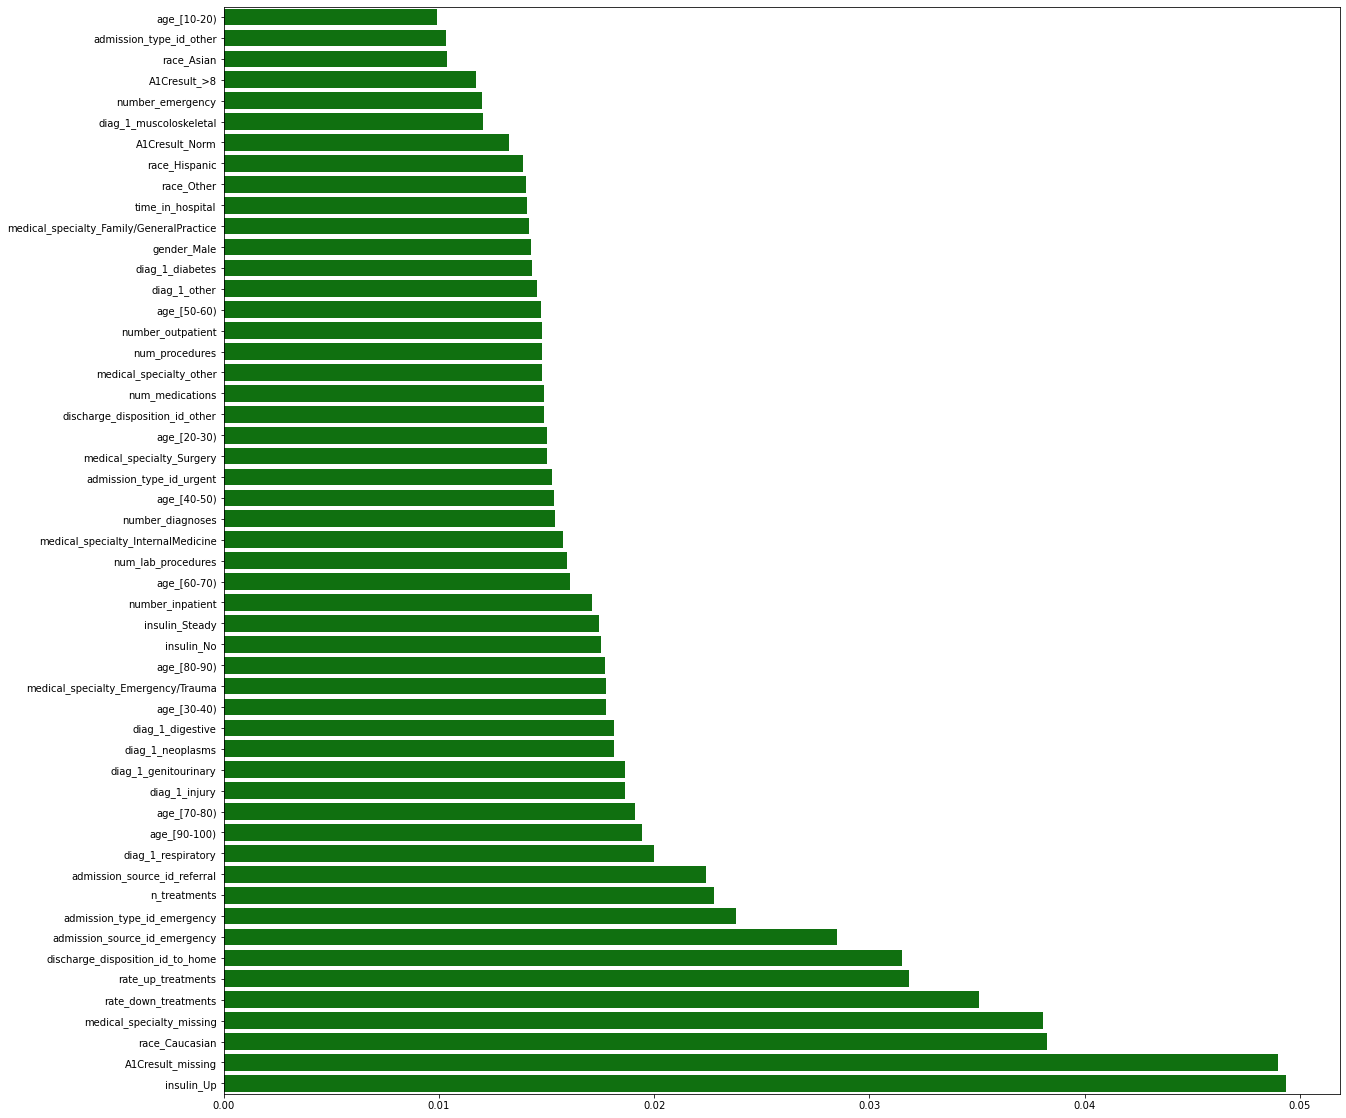

In [104]:
GiniScore,j=np.sort(xgb_clf.feature_importances_),np.argsort(xgb_clf.feature_importances_)
plt.figure(figsize=(20, 20)) 
sns.barplot(y=feature_names[j], x=GiniScore, color='g', )

<AxesSubplot:>

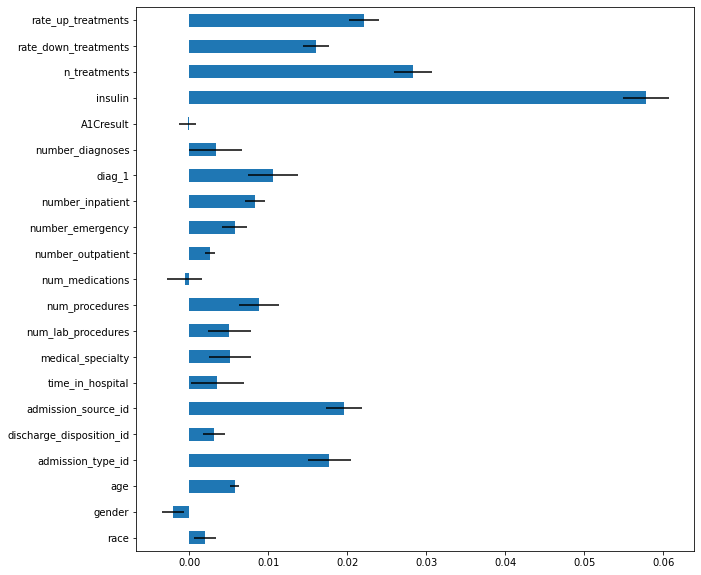

In [112]:
def f1_weighted_score(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y, y_pred, average='weighted')

result = permutation_importance(best_model, X_test, y_test_enc, n_repeats=5, random_state=42, scoring=f1_weighted_score)
f_importances = pd.Series(result.importances_mean, index=X_test.columns)
plt.figure(figsize=(10, 10)) 
f_importances.plot.barh(xerr=result.importances_std)

## AdaBoost

 Now let's try a different model, still based on decision trees: **Boosting**.

 While Random Forest reduces overfitting by averaging many decision trees (bagging), Boosting works differently: it builds generally small trees sequentially, where each new tree attempts to correct the errors made by the previous ones.

 This iterative process helps to **reduce bias** and often results in better performance, especially on more complex tasks.
 Let's see if Boosting can outperform our previous models.

We now proceed with defining and training an AdaBoost model. 

In [ ]:
base_clf = DecisionTreeClassifier(max_depth=3)

# Define pipeline: preprocessing + AdaBoost classifier
pipeline_boost = Pipeline([('preprocessor', preprocessor),
                          ('classifier', AdaBoostClassifier(estimator=base_clf, n_estimators=500))])


# Hyperparameter grid 
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__estimator__max_depth': [1, 3, 5]
}

# Perform Grid Search 
grid_search = GridSearchCV(
    pipeline_boost,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,
    verbose=3,
    n_jobs=-1,
    error_score='raise'
)

# Fit on resampled (balanced) training data
grid_search.fit(X_resampled, y_resampled)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['time_in_hospital',
                                                                          'num_lab_procedures',
                                                                          'num_procedures',
                                                                          'num_medications',
                                                                          'number_outpatient',
                                                                          'number_emergency',
                                                                          'number_inpatient',
                                                                          'number_diagnoses',
                                                                          'n_treatments',
                                                                          'rate_down_treatments',
                                                                          'rate_up_treatments']),...
                                                                          'admission_type_id',
                                                                          'discharge_disposition_id',
                                                                          'admission_source_id',
                                                                          'medical_specialty',
                                                                          'diag_1',
                                                                          'A1Cresult',
                                                                          'insulin'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                           n_estimators=500))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__max_depth': [1, 3, 5],
                         'classifier__n_estimators': [100, 300, 500]},
             scoring='f1_macro', verbose=3)

In [67]:
# Extract best model from the grid search
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the train and test set
y_pred_boost_train = best_model.predict(X_resampled)
y_pred_boost = best_model.predict(X_test)

# Accuracy on training set
print("On training set:")
print("Accuracy :", accuracy_score(y_resampled, y_pred_boost_train))
print("F1 (weighted):", f1_score(y_resampled, y_pred_boost_train, average='weighted'))

# Evaluate accuracy 
print("On test set:")
print("Accuracy :", accuracy_score(y_test, y_pred_boost))
print("F1 (weighted):", f1_score(y_test, y_pred_boost, average='weighted'))


Best Parameters: {'classifier__estimator__max_depth': 5, 'classifier__n_estimators': 500}
On training set:
Accuracy : 0.763991363284723
F1 (weighted): 0.764042918433494
On test set:
Accuracy : 0.5029164722351843
F1 (weighted): 0.505336200599442


### Feature importance for AdaBoost

Here below, as usual, we try 2 appraoches: impurity-based feature importance and permutation importance.

1.Impurity-based feature importance:

In [68]:
# Estract the model from the pipeline
boost_clf=best_model.named_steps['classifier']

# feature importance
boost_clf.feature_importances_

array([0.0836403 , 0.19823771, 0.05390896, 0.13592599, 0.02069985,
       0.01066475, 0.01733604, 0.06362067, 0.03638162, 0.01725502,
       0.01592658, 0.00118276, 0.01521697, 0.00147804, 0.00143524,
       0.02570791, 0.00048334, 0.00168864, 0.00297707, 0.00767205,
       0.01340012, 0.01521293, 0.01519856, 0.01331816, 0.00403773,
       0.01126983, 0.00055496, 0.00932697, 0.00051228, 0.01838655,
       0.01113634, 0.010632  , 0.00650157, 0.00554869, 0.01075146,
       0.00485896, 0.01400101, 0.0075901 , 0.00676333, 0.01215025,
       0.00782732, 0.00783742, 0.00526335, 0.00490381, 0.01393353,
       0.01117381, 0.00551878, 0.00476353, 0.00766088, 0.01192764,
       0.01294304, 0.00365558])

In [69]:
# get the transformer OneHotEncoder from the pipeline
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']

# Get the names of the numeric features 
num_feats = numeric_columns

# Get the names of the categorical features 
cat_feats = ohe.get_feature_names_out(categoric_columns)

# Combine the names of the features
feature_names = np.concatenate([num_feats, cat_feats])

<AxesSubplot:>

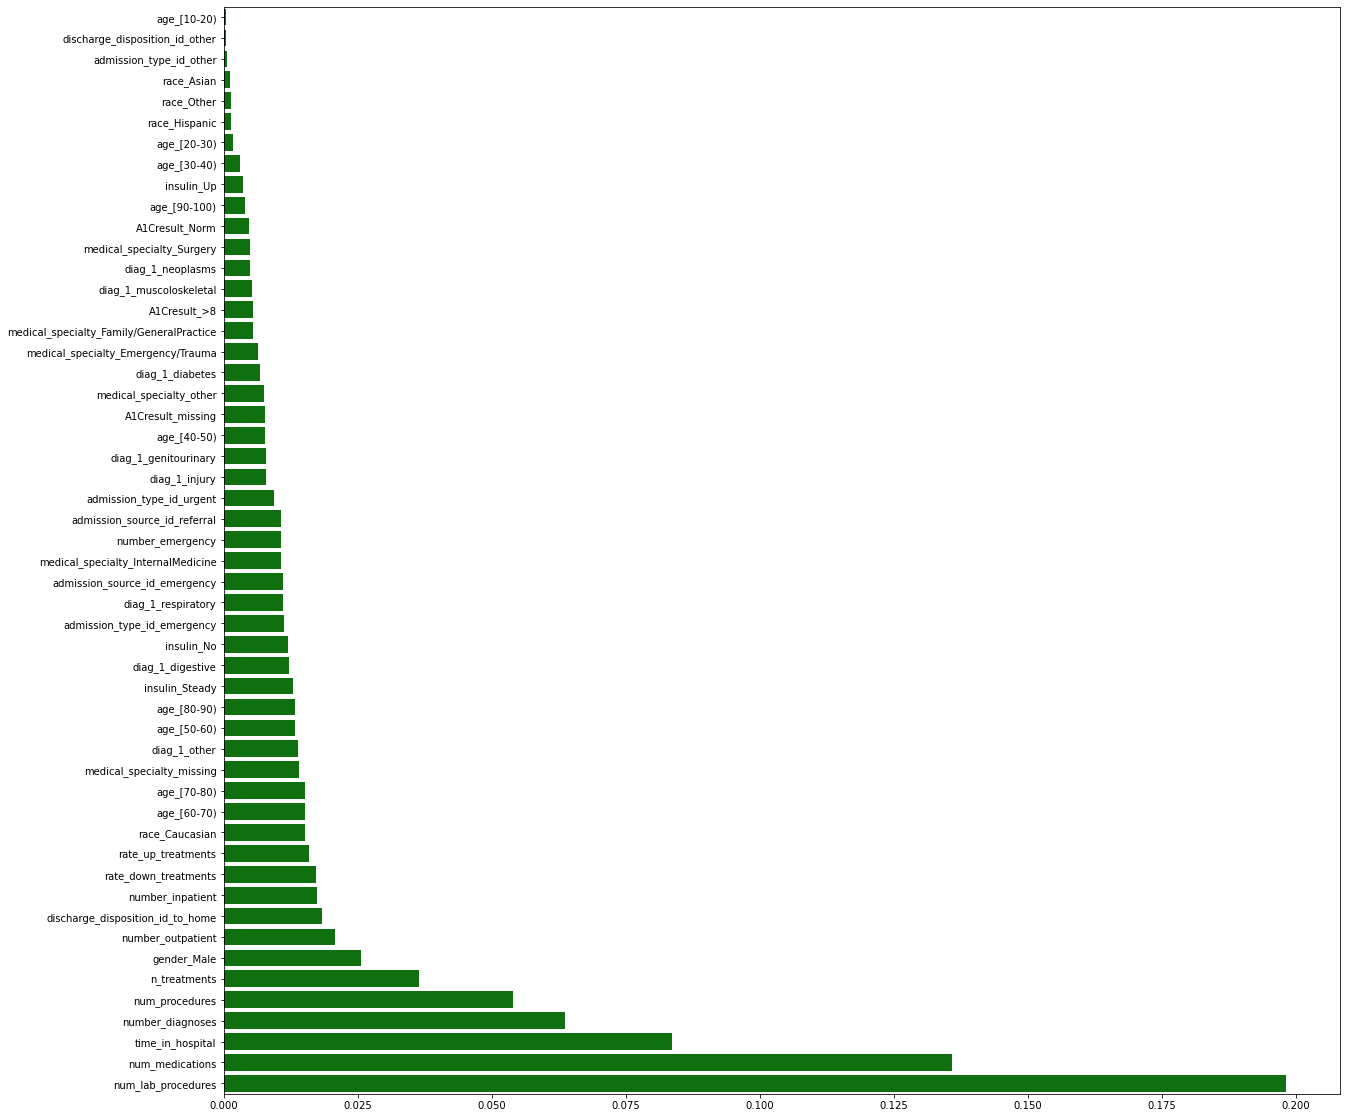

In [70]:
GiniScore,j=np.sort(boost_clf.feature_importances_),np.argsort(boost_clf.feature_importances_)
plt.figure(figsize=(20, 20)) 
sns.barplot(y=feature_names[j], x=GiniScore, color='g', )

2.Permutation importance

<AxesSubplot:>

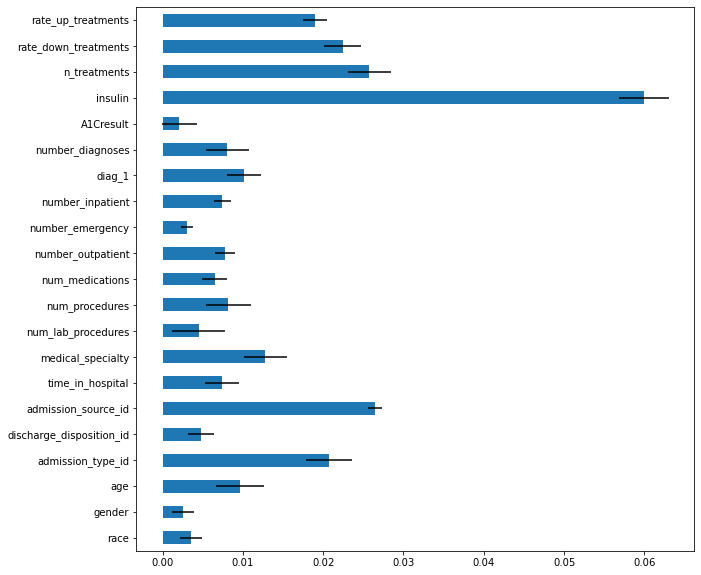

In [72]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42, scoring=f1_weighted_score)
f_importances = pd.Series(result.importances_mean, index=X_test.columns)
plt.figure(figsize=(10, 10)) 
f_importances.plot.barh(xerr=result.importances_std)

Although we expected an improvement in F1 score, we did **not** observe a **significant gain**. However, we noticed that the most relevant features identified by this model differ from those found in other models — particularly variables like insulin, n_treatments, rate_up_treatments, and rate_down_treatments. This suggests that the model may be capturing **different patterns** and interactions among the variables, which could be valuable when combining models in an ensemble approach.

## Ensamble method with majority voting: Logistic regression, Random Forest, AdaBoost

We build a majority voting ensemble using Logistic Regression, Random Forest, and AdaBoost. Each model is inside a pipeline with its own preprocessing and tuned settings. With **hard voting**, the final prediction is based on the majority vote across models.
This could help improve accuracy, makes predictions more robust and may reduce overfitting from individual classifiers, although it becomes extremely hard to interpret.

In [73]:
pipeline.set_params(classifier__C=1e-2)

voting_clf = VotingClassifier(estimators=[('lr', pipeline), ('rf', pipeline_rf), ('svc', pipeline_boost)], voting='hard')
voting_clf.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preproc',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['time_in_hospital',
                                                                                 'num_lab_procedures',
                                                                                 'num_procedures',
                                                                                 'num_medications',
                                                                                 'number_outpatient',
                                                                                 'number_emergency',
                                                                                 'number_inpatient',
                                                                                 'number_diagnoses',
                                                                                 'n_treatments',
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncod...
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore'),
                                                                                ['race',
                                                                                 'gender',
                                                                                 'age',
                                                                                 'admission_type_id',
                                                                                 'discharge_disposition_id',
                                                                                 'admission_source_id',
                                                                                 'medical_specialty',
                                                                                 'diag_1',
                                                                                 'A1Cresult',
                                                                                 'insulin'])])),
                                              ('classifier',
                                               AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                                  n_estimators=500))]))])

In [ ]:
y_pred = voting_clf.predict(X_test)
print('Hard-Majority voting accuracy', accuracy_score(y_test, y_pred))
print('Hard-Majority voting F1', f1_score(y_test, y_pred, average='weighted'))


Hard-Majority voting accuracy 0.508749416705553
Hard-Majority voting F1 0.5156738610536352


We now switch to **soft voting**, which averages predicted class probabilities from each model. Unlike hard voting, it considers how confident each model is in its predictions.  This can lead to better performance if the models are well-calibrated.  

In [ ]:
voting_clf2 = VotingClassifier(estimators=[('lr', pipeline), ('rf', pipeline_rf), ('svc', pipeline_boost)], voting='soft')
voting_clf2.fit(X_resampled, y_resampled)


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preproc',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['time_in_hospital',
                                                                                 'num_lab_procedures',
                                                                                 'num_procedures',
                                                                                 'num_medications',
                                                                                 'number_outpatient',
                                                                                 'number_emergency',
                                                                                 'number_inpatient',
                                                                                 'number_diagnoses',
                                                                                 'n_treatments',
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncod...
                                                                                 'rate_down_treatments',
                                                                                 'rate_up_treatments']),
                                                                               ('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore'),
                                                                                ['race',
                                                                                 'gender',
                                                                                 'age',
                                                                                 'admission_type_id',
                                                                                 'discharge_disposition_id',
                                                                                 'admission_source_id',
                                                                                 'medical_specialty',
                                                                                 'diag_1',
                                                                                 'A1Cresult',
                                                                                 'insulin'])])),
                                              ('classifier',
                                               AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                                  n_estimators=500))]))],
                 voting='soft')

In [76]:
y_pred2 = voting_clf2.predict(X_test)
print('Soft-Majority voting accuracy', accuracy_score(y_test, y_pred))
print('Soft-Majority voting F1', f1_score(y_test, y_pred, average='weighted'))

Soft-Majority voting accuracy 0.508749416705553
Soft-Majority voting F1 0.5156738610536352


We actually observe that the F1 scores from both hard voting and soft voting ensemble methods are slightly lower than that of the tuned Random Forest model.
This may be justified by the fact that, although ensemble methods aim to leverage the strengths of multiple models, the individual models included may **not** be **diverse or complementary enough** to significantly enhance performance.
Additionally, if one model consistently outperforms the others, combining it with weaker models can **dilute its predictive power**, leading to marginally worse results.

# Conclusions

questa è una modifica di prova

Ho creato un altro branch, dove dovrebbe apparire la modifica fatta al file. 